<a href="https://colab.research.google.com/github/tarek2004-l/Predicting-Risk-Of-Diabetes-Using-Patient-Data/blob/main/Retail_sles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [20]:
df.describe()

,Row ID,Order Date,Postal Code,Sales
count,9800.000000,9800,9789.000000,9800.000000
mean,4900.500000,2017-05-01 05:13:51.673469440,55273.322403,230.769059
min,1.000000,2015-01-03 00:00:00,1040.000000,0.444000
25%,2450.750000,2016-05-24 00:00:00,23223.000000,17.248000
50%,4900.500000,2017-06-26 00:00:00,58103.000000,54.490000
75%,7350.250000,2018-05-15 00:00:00,90008.000000,210.605000
max,9800.000000,2018-12-30 00:00:00,99301.000000,22638.480000
std,2829.160653,NaN,32041.223413,626.651875


In [6]:
print(df['Category'].value_counts())

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64


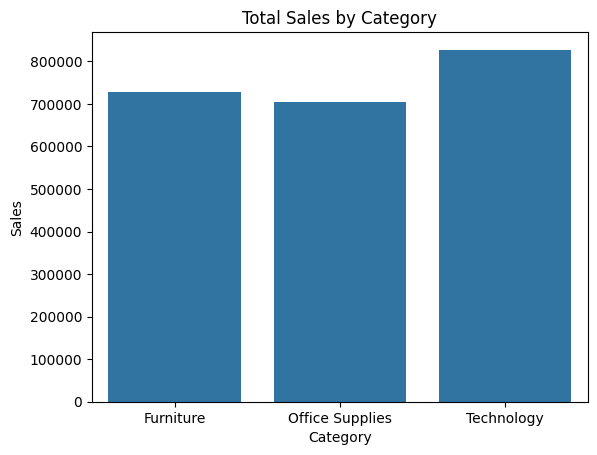

In [7]:
category_sales = df.groupby('Category')['Sales'].sum().reset_index()
sns.barplot(x='Category', y='Sales', data=category_sales)
plt.title("Total Sales by Category")
plt.show()

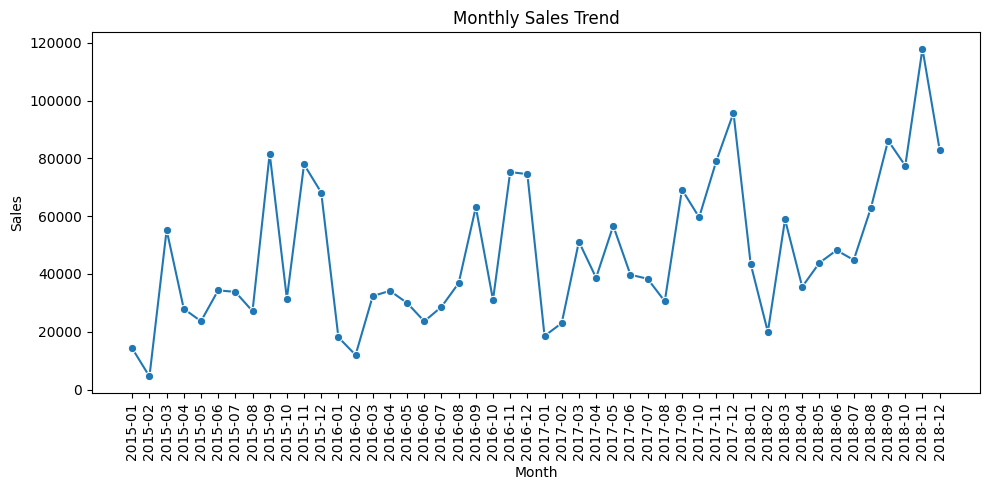

In [45]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Month'] = df['Order Date'].dt.to_period('M')

monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Sales', data=monthly_sales, marker='o')
plt.xticks(rotation=90)
plt.title("Monthly Sales Trend")
plt.tight_layout()
plt.show()


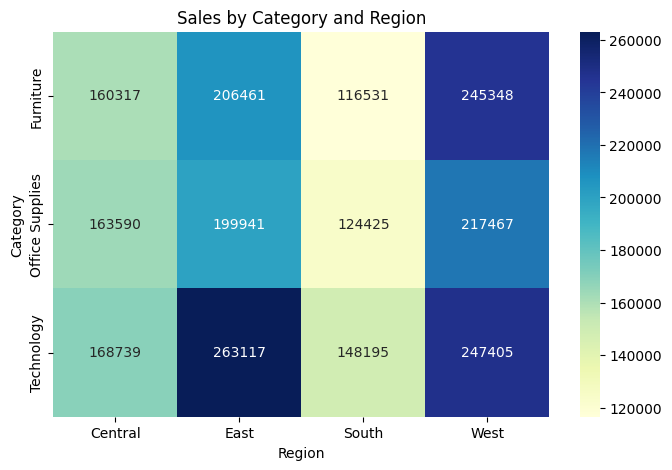

In [19]:
heatmap_data = df.pivot_table(values='Sales', index='Category', columns='Region', aggfunc='sum')
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales by Category and Region")
plt.show()


In [24]:
customer_df = df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Order ID': 'nunique',
    'Order Date': ['min', 'max']
})

customer_df.columns = ['Total_Sales', 'Order_Count', 'First_Order', 'Last_Order']
customer_df = customer_df.reset_index()

latest_date = df['Order Date'].max()
customer_df['Recency'] = (latest_date - customer_df['Last_Order']).dt.days


In [25]:
features = customer_df[['Total_Sales', 'Order_Count', 'Recency']]
features = features.fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


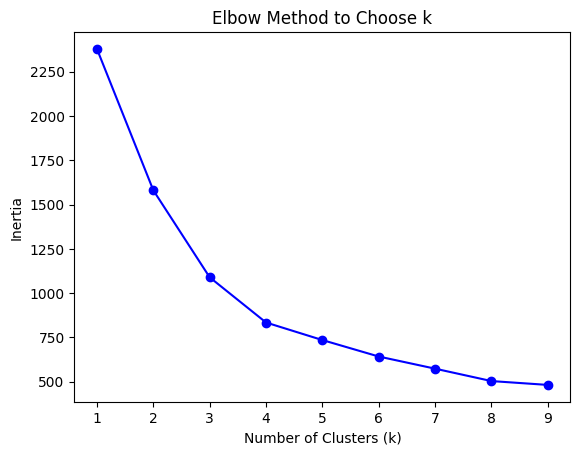

In [26]:
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Choose k')
plt.show()


In [32]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)

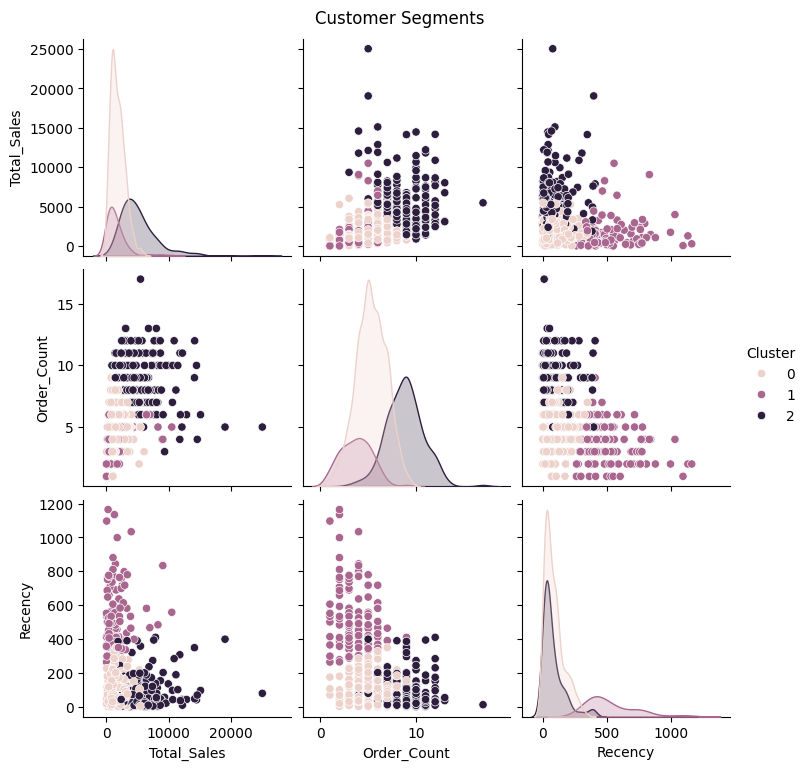

In [43]:
sns.pairplot(customer_df.reset_index(), hue='Cluster',
             vars=['Total_Sales', 'Order_Count', 'Recency'])
plt.suptitle("Customer Segments", y=1.02)
plt.show()


In [42]:
customer_df.groupby('Cluster')[['Total_Sales','Order_Count', 'Recency']].mean()
#cluster 2 has the highest sale and lowest recency, considered as a vip costumer.


,Total_Sales,Order_Count,Recency
Cluster,,,
0,1785.568885,5.292162,86.928741
1,1566.942719,3.730435,526.452174
2,5173.594823,8.813230,79.579767


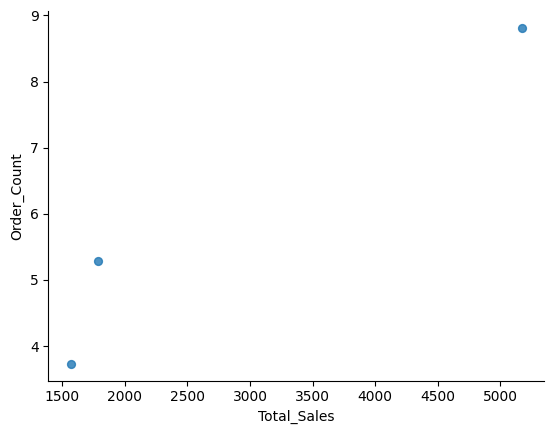

In [36]:
from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='Total_Sales', y='Order_Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)